# Customer Service machine learning model 

The main objective of this project is to help a startup in the logistics and delivery domain thrive on making its customers happy. As a growing startup, with a global expansion strategy, it needs to make its customers happy by measuring how happy each customer is. The prediction of effects that make customers happy or not can help in taking necessary actions. Getting feedback from customers was a crucial step that the company made as part of a survey. Therefore, the used data is a subset of this survey to a select customer cohort.   
This notebook demonstrates how did I use Machine Learning techniques as well as feature engineering methods to help the company much classify its customers, and then make pertinent decisions.   
Below, these are the main steps followed to solve the problem:
* Exploring, visualizing, describing, and understanding the dataset.
* Splitting the dataset into Train and Test sets.
* Training different Machine Learning models on the data.
* Evaluating models and analyzing results.
* Applying Feature Selection to show important features and then their impact on results.
* Making Shap Analysis on the dataset to understand it more and know how much was a prediction driven by the variation of some features.
* Making accurate decisions for the company. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lazypredict
from lazypredict.Supervised import LazyClassifier
#for models
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
# feature selection
from sklearn.feature_selection import SelectFromModel
#save models
import joblib
#shap analysis
import shap

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Visualization of data


> ##### From the code below, we can see that the data contains 126 lines and 7 columns: 6 features (X1 to X6) and the target (Y)

In [2]:
df=pd.read_csv("ACME-HappinessSurvey2020.csv")
print('There are {} lines and {} columns'.format (df.shape[0],df.shape[1]))

There are 126 lines and 7 columns


▶ Here is the meaning of each variable in the data: 
  *  Y = target attribute with values indicating 0 (unhappy) and 1 (happy) customers  
  *  X1 = my order was delivered on time  
  *  X2 = contents of my order was as I expected  
  *  X3 = I ordered everything I wanted to order  
  *  X4 = I paid a good price for my order  
  *  X5 = I am satisfied with my courier  
  *  X6 = the app makes ordering easy for me  
  *  Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5, 
  where the smaller number indicates less and the higher number indicates more towards the answer.

In [3]:
# First 5 rows of our dataset
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5




> ### Let us explore more our dataset 



* Because all values of the 'count' row below are the same for all variables, we can dedicate that there are no missing values in our dataset.
* From the 'std' row below, we can say that features X5 and X2 are the most variant features (they have high values of variance in comparison with other features).
* From the 'mean' row below, we can notice that the feature X2 has the smaller value, so the most problem for the company is that contents of the client's order weren't as they expected.  
In contrary, X1 and X6 have the biggest values of 'mean', so the two most advantages of this company are the delivery of orders on time and the easy ordering with its app.


In [4]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00



*   From the cell below, we can see that 69 clients were happy. However, 57 clients were unhappy. So the percentage of unsatisfaction of clients is about 45%, which is not very good in general for the success of this company.


1    69
0    57
Name: Y, dtype: int64
degree of unhappiness is: 0.4523809523809524


<AxesSubplot:>

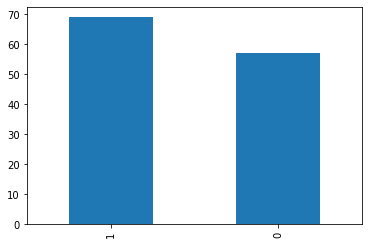

In [5]:
print(df['Y'].value_counts())
print('degree of unhappiness is:', df['Y'].value_counts()[0]/(df['Y'].value_counts()[0]+df['Y'].value_counts()[1]))
df['Y'].value_counts().plot.bar()


▶  Correlation map
  *   X1 is more correlated with X5 and X6, 
  *   Y is correlated with X1 and X5 and have less correlation with X2 and x4, so we can say that the happiness of clients depends more on the degree of their satisfaction with their courier and also the delivery of orders on time.
  However, the expectation of content and the good price don't affect a lot on their happiness.
  *   X3 is more correlated with X5 and X4 
  *   X6 is less correlated with X2 

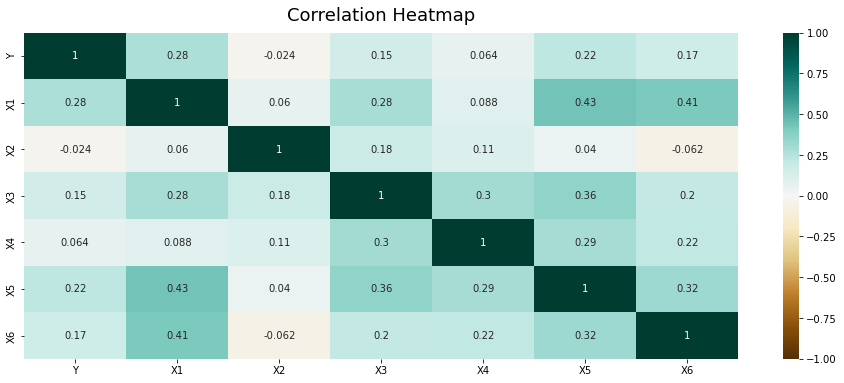

In [6]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# save heatmap as png file
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

# Modeling


*   Splitting the dataset: let us take 20% of the data for the test and 80% for the train.
*   Features of our data are X1, X2, X3, X4, X5, and X6.
*   Target of our data is the variable Y.

In [7]:
np.random.seed(1)
X=df.drop('Y', axis=1) # select the features of our dataset
Y=df['Y'] # select the target Y
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2)

>##### Testing all basic machine learning models. Because we have a classification problem, we will test just models of classification using the lazyClassifier package

In [8]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:02<00:00, 11.18it/s]


In [9]:
# Below, the result of base models fitted on our dataset
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.62,0.59,0.59,0.62,0.02
AdaBoostClassifier,0.62,0.57,0.57,0.61,0.30
BaggingClassifier,0.58,0.54,0.54,0.57,0.12
BernoulliNB,0.58,0.54,0.54,0.57,0.08
NuSVC,0.58,0.54,0.54,0.57,0.06
LGBMClassifier,0.54,0.53,0.53,0.54,0.06
LabelSpreading,0.54,0.51,0.51,0.54,0.06
XGBClassifier,0.54,0.51,0.51,0.54,0.29
DummyClassifier,0.54,0.51,0.51,0.54,0.02


*   Let's select 5 top best models based on the Accuracy metric.    

In [10]:
best_models=models.sort_values(by=['Accuracy'], ascending=False).index.tolist()
list_models=best_models[:5]
list_models

['DecisionTreeClassifier',
 'AdaBoostClassifier',
 'BaggingClassifier',
 'BernoulliNB',
 'NuSVC']

▶  Now, let's make some hyperparameter optimization:
*  Creating a dictionary whose keys are the name of each model selected.
* We will also test the RandomForestClassifier model


In [11]:
dict_models=dict()
# It will be also necessary to test the Randomforestclassifier model
list_models.append('RandomForestClassifier')
dict_models.fromkeys(list_models)

{'DecisionTreeClassifier': None,
 'AdaBoostClassifier': None,
 'BaggingClassifier': None,
 'BernoulliNB': None,
 'NuSVC': None,
 'RandomForestClassifier': None}

*  Let's define a function that load each selected model while calling its name

In [12]:
def load_model(name):
    if name=="DecisionTreeClassifier":
        model=DecisionTreeClassifier()
    elif name=="AdaBoostClassifier":
        model=AdaBoostClassifier()
    elif name=="BaggingClassifier":
        model=BaggingClassifier()
    elif name=="NuSVC":
        model=NuSVC() 
    elif name=="BernoulliNB":
        model=BernoulliNB() 
    elif name=="RandomForestClassifier":
        model=RandomForestClassifier() 
    return model

*  Testing 50 values of random_state parameter on the 6 selected models.
*  Storing best models as values of the dictionary created.
*  Plotting metric report of each model.

In [13]:
np.random.seed(0)
for model in list_models:
    L=[]
    for i in range(0,50):
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=i)
        modele =load_model(model)
        modele.fit(X_train,Y_train)
        sc_train=modele.score(X_train,Y_train)
        sc_test=modele.score(X_test,Y_test)
        L.append(sc_test)
        if sc_test >= max(L):
            model_max=modele
    dict_models[model]=model_max
    print("best score of ",model,"is :",max(L),"with the random_state:",L.index(max(L)))
    Y_pred = dict_models[model].predict(X_test)
    print("\n report of the model: ", model,"\n", metrics.classification_report(Y_test, Y_pred),"\n")

best score of  DecisionTreeClassifier is : 0.7307692307692307 with the random_state: 21

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.93      0.96        14

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26
 

best score of  AdaBoostClassifier is : 0.6923076923076923 with the random_state: 21

 report of the model:  AdaBoostClassifier 
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.67      0.86      0.75        14

    accuracy                           0.69        26
   macro avg       0.71      0.68      0.68        26
weighted avg       0.71      0.69      0.68        26
 

best score of  BaggingClassifier is : 0.8076923076923077 with the random_sta

* The best accuracy from the result above is for the Decision Tree Classifier with an accuracy = 96%.
* Therefore, the recall is equal to 1 for class 0, which means that all unhappy customers were predicted with the right class (class 0). So, the company has more chance to handle with its unhappy customers and know what makes them unsatisfied.


### Confusion matrix

*  Let's take an example of the confusion matrix of the Decision Tree model: We can see that all 12 values, from the Test set, of class 0 were well predicted, which confirmed the value of the recall of class 0. However, just 1 label of 14 from the Test set, from class 1 was wrong predicted. 

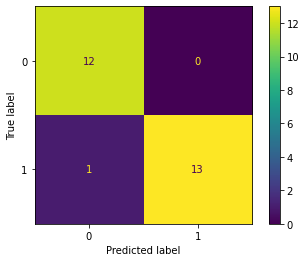

In [14]:
plot_confusion_matrix(dict_models['DecisionTreeClassifier'], X_test, Y_test)  
plt.show()

*  Let's take an other example of confusion matrix of the random forest model with an accuracy=92% :    
   We can see that just 1 label of 12 from the class 0 was wrong predicted. However, just 1 of 13 labels from the class 1 that was wrong predicted.

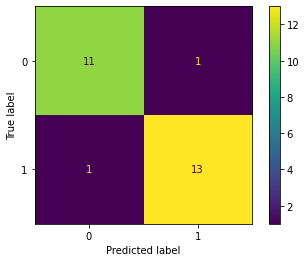

In [15]:
plot_confusion_matrix(dict_models['RandomForestClassifier'], X_test, Y_test)  
plt.show()

Now, let's check the scores of Accuracy and Recall of both DecisionTree and RandomForest models, which have the best results from the previous section.

In [16]:
Y_pred_dt = dict_models['DecisionTreeClassifier'].predict(X_test)
print('recall of DecisionTreeClassifier is:',metrics.recall_score(Y_test,Y_pred_dt))
print('accuracy of DecisionTreeClassifier is:',metrics.accuracy_score(Y_test,Y_pred_dt))

recall of DecisionTreeClassifier is: 0.9285714285714286
accuracy of DecisionTreeClassifier is: 0.9615384615384616


In [17]:
Y_pred_rf = dict_models['RandomForestClassifier'].predict(X_test)
print('recall of RandomForestClassifier is:',metrics.recall_score(Y_test,Y_pred_rf))
print('accuracy of RandomForestClassifierr is:',metrics.accuracy_score(Y_test,Y_pred_rf))

recall of RandomForestClassifier is: 0.9285714285714286
accuracy of RandomForestClassifierr is: 0.9230769230769231


### First Decision

 >  From all these results, selecting the DecisionTree model as the best one for our case. In fact, even if the two models have the same value of Recall, the DecisionTree model detects perfectly unhappy customers. Therefore, it has also the highest accuracy. So, let's take it as our base model for the next steps.

*  Before applying some feature selection, let's save the two models locally.

In [18]:
# save models to disk
fil_dtm = 'DecisionTree_model_best.sav'
fil_rfm = 'RandomForestClassifier_model_best.sav'
joblib.dump(dict_models['DecisionTreeClassifier'], fil_dtm)
joblib.dump(dict_models['RandomForestClassifier'], fil_rfm)

['RandomForestClassifier_model_best.sav']

In [186]:
#  here is the code to load the model from disk
'''
loaded_model = joblib.load('DecisionTree_model_best.sav')
result = loaded_model.score(X_test, Y_test)
print(result)
'''

"loaded_model = joblib.load('DecisionTree_best.sav')\nresult = loaded_model.score(X_test, Y_test)\nprint(result)"

# Tree-based Feature Selection

   The Feature Selection method helps us to select important features using different methods. Here, we will use the Tree_based Feature Selection method using the DecisionTree model, on the base model selected.

###  Befor feature selection

Checking the Recall and the Accuracy scores for our base model before applying some feature selection.

In [19]:
# Without feature selection, check auuracy with the Random forest model
Y_pred_dt = dict_models['DecisionTreeClassifier'].predict(X_test)
print('recall:',metrics.recall_score(Y_test,Y_pred_dt))
print('accuracy:',metrics.accuracy_score(Y_test,Y_pred_dt))

recall: 0.9285714285714286
accuracy: 0.9615384615384616


### After feature selection

* Below, the graph shows the importance of features related to their impurity. Decrease the impurity of features, more important is. X5, X4, X1, and X3 are the most important features from this graph.

<AxesSubplot:xlabel='Features', ylabel='Importances'>

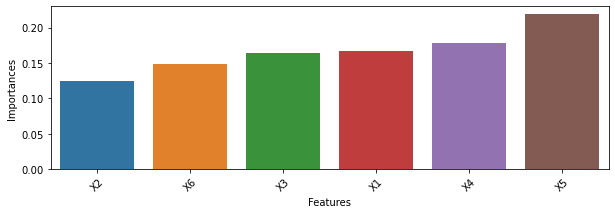

In [20]:
# get the importance of the resulting features.
importances = dict_models['DecisionTreeClassifier'].feature_importances_
# create a data frame for visualization.
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
plt.figure(figsize=(10,3))
plt.xticks(rotation=45)
sns.barplot(x="Features",y= "Importances", data=final_df)

*  To be more precise, let's select important features using the SelectFromModel method: The result is 3 features: X1, X3, and X5

In [21]:
np.random.seed(2)
selector=SelectFromModel(dict_models['DecisionTreeClassifier'])
selector.fit_transform(X_train,Y_train)
selector.get_support()
selected_feat=X.columns[(selector.get_support())]
selected_feat

Index(['X1', 'X3', 'X5'], dtype='object')

In [22]:
#Define an other dictionary to store best models after applying the feature selection
dict_models_2=dict()
dict_models_2.fromkeys(list_models)

{'DecisionTreeClassifier': None,
 'AdaBoostClassifier': None,
 'BaggingClassifier': None,
 'BernoulliNB': None,
 'NuSVC': None,
 'RandomForestClassifier': None}

In [23]:
#Reconstitute the dataset with dropping unimpotant features based on the previous selection
new_df=df.drop(['X2','X4','X6'],axis=1)
X_new=new_df.drop('Y', axis=1) # select the features X1, X5 and X3
Y_new=new_df['Y'] # select the target Y
#splitting new data to train and test sets
X_train_n,X_test_n,Y_train_n,Y_test_n=train_test_split(X_new,Y_new, test_size=0.2)

*  Now, testing basic ML models on the new dataset

In [24]:
np.random.seed(0)
for model in list_models:
    L=[]
    for i in range(0,50):
        X_train_n,X_test_n,Y_train_n,Y_test_n=train_test_split(X_new,Y_new, test_size=0.2, random_state=i)
        modele =load_model(model)
        modele.fit(X_train_n,Y_train_n)
        sc_train=modele.score(X_train_n,Y_train_n)
        sc_test=modele.score(X_test_n,Y_test_n)
        L.append(sc_test)
        if sc_test >= max(L):
            model_max=modele
    dict_models_2[model]=model_max
    print("best score of ",model,"is :",max(L),"with the random_state:",L.index(max(L)))
    Y_pred_n = dict_models_2[model].predict(X_test_n)
    print("\n report of the model: ", model,"\n", metrics.classification_report(Y_test_n, Y_pred_n),"\n")

best score of  DecisionTreeClassifier is : 0.8076923076923077 with the random_state: 8

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.79      0.79      0.79        14

    accuracy                           0.77        26
   macro avg       0.77      0.77      0.77        26
weighted avg       0.77      0.77      0.77        26
 

best score of  AdaBoostClassifier is : 0.7307692307692307 with the random_state: 8

 report of the model:  AdaBoostClassifier 
               precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.60      0.64      0.62        14

    accuracy                           0.58        26
   macro avg       0.57      0.57      0.57        26
weighted avg       0.57      0.58      0.58        26
 

best score of  BaggingClassifier is : 0.8076923076923077 with the random_state

> Selecting the best model from the result above, based on Recall and accuracy scores, which is: the **RandomForest** model with an accuracy equal to 81%.
  Now, let's check the value of both Accuracy and Recall scores after the Feature Selection method.

In [25]:
Y_pred_rf = dict_models_2['RandomForestClassifier'].predict(X_test_n)
print('recall:',metrics.recall_score(Y_test_n,Y_pred_rf))
print('accuracy:',metrics.accuracy_score(Y_test_n,Y_pred_rf))

recall: 0.8571428571428571
accuracy: 0.8076923076923077


> ##### For our case, we can see that even with the feature selection using the Decision Tree model, the base model selected is much better. In fact, either for the Accuracy or the Recall scores, the base model has the highest values. Therefore, in our case, we should look more for the best value of the Recall, as the company might give more importance to detect their unhappy customers, and then to know what affects their happiness over its orders.

# SHAP Analysis

*  To analyze more our results, let's make some analysis with the Shapley Additive Explanations (SHAP) method, which explains the prediction results of a machine learning model. Let's choose our base model which is the DecisionTree Classifier

In [26]:
DecisionTree_model = dict_models['DecisionTreeClassifier']

In [27]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(DecisionTree_model)
# obtain shap values for the first row of the test data
shap_values = explainer.shap_values(X_test.iloc[0])

In [28]:
#exploring the shap values, it contains 2 arrays of either the class 0 and 1 of our dataset.
shap_values

[array([ 0.15690979,  0.09985886,  0.07265303,  0.01352666,  0.20783232,
        -0.04078065]),
 array([-0.15690979, -0.09985886, -0.07265303, -0.01352666, -0.20783232,
         0.04078065])]

>  In Shap Analysis, there are different methods of exploring the data. Let's see some of them to understand our results  more .

### 1- Individual explanation 

* Let's choose the first row of the test set. 
* As we can see in the red color block, the X5 has the largest size. This indicates that high values of X5 had a greater impact on the prediction results. In the blue color block, low values of X6 have the greatest impact.
* From the above force plot, we can make the following conclusion:   
**Our model was able to make the right prediction. This is because the Output value is 1.0, which is above the base value of 0.49.**

In [29]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0]) 

NB:     
* Red: Features that push the prediction to the base line.          
* Blue: Features that pull the prediction lower from the base line.

### 2-  Shap summary plot
This method brings the whole data to a single plot.

From the plot below, It can be observed that the feature ‘X1’ contributes greatly to the model’s prediction with low values deciding the class 0 and higher values deciding the other class.

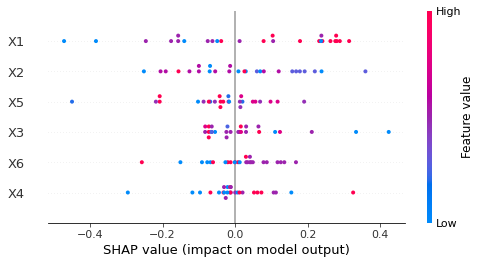

In [31]:
#SHAP Summary Plot
shap.summary_plot(shap_values[1], X_test)

Summary plot can also be visualized as a bar plot as followed for quick reading. 
* It is clearly observed that X1 has the highest impact and X4 has the least impact.

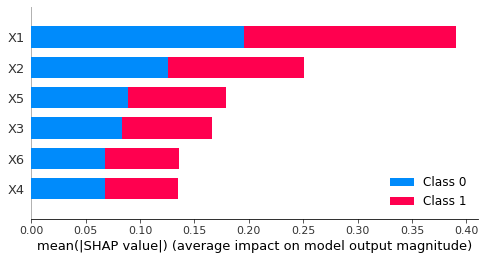

In [32]:
#SHAP Feature Importance
shap.summary_plot(shap_values,X_test, plot_type='bar')

### 3- SHAP Dependence Plot
Dependence plots can be of great use while analyzing feature importance and doing feature selection. It makes one-versus-one plot against two features by plotting shap values of one feature and coloring the dots concerning another interactive feature.

* Let's take an example of X1, and show its interaction with other features.

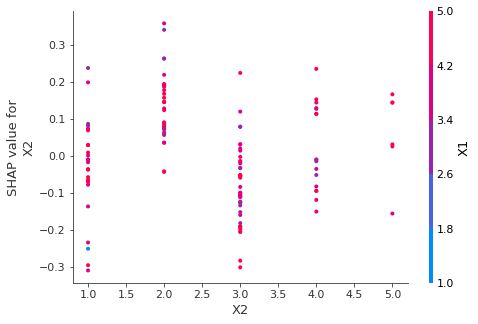

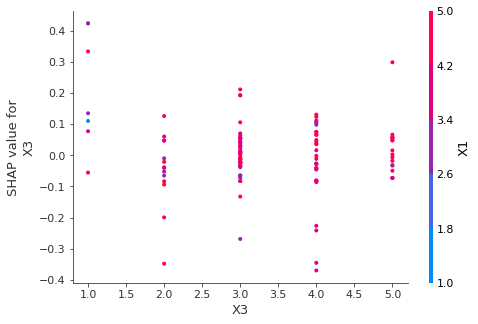

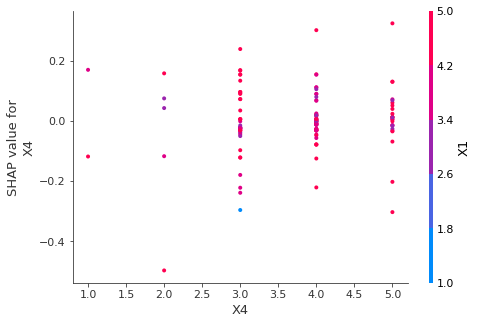

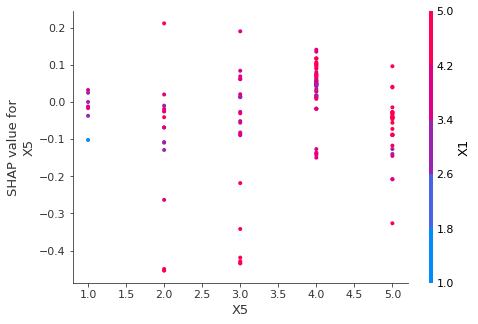

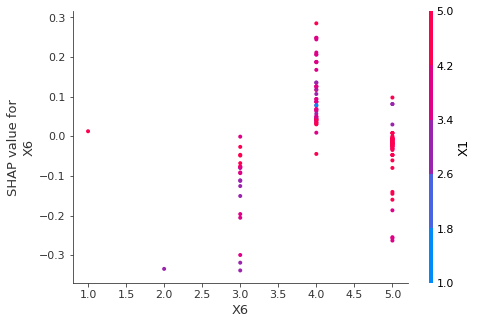

In [31]:
# SHAP Dependence Plot
shap_values = explainer.shap_values(X)
shap.dependence_plot('X2', shap_values[1], X, interaction_index='X1') 
shap.dependence_plot('X3', shap_values[1], X, interaction_index='X1') 
shap.dependence_plot('X4', shap_values[1], X, interaction_index='X1') 
shap.dependence_plot('X5', shap_values[1], X, interaction_index='X1') 
shap.dependence_plot('X6', shap_values[1], X, interaction_index='X1') 

### 4- SHAP Decision Plot
As the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values. It can be observed that certain strings colored in blue resulted in final class value 0 and the remaining strings colored in red resulted in final class value 1.

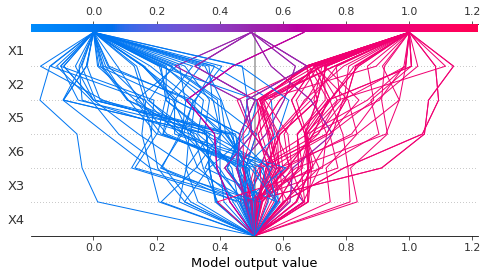

In [34]:
#SHAP Decision Plot
shap.decision_plot(explainer.expected_value[1], shap_values[1], X)

## Conclusion

In this project, I started by exploring and visualizing the dataset. After assuring that the data is pretty cleaned, I was able to test different machine learning models and store the best ones based on their Recall and Accuracy. The best model selected was able to predict if a customer is happy or not, with an accuracy of 96% and a Recall of 100% for class 0 and 93% for the other class. That was a good score as the company can know what affects more the happiness of its customers.    
Therefore, applying feature engineering was necessary. It involves selecting important features using the based Tree_Based Feature Selection method and then retraining the model with the new database to see the impact of the selected features in results. The Accuracy was reduced to 80 % and the Recall to 82%, which allowed me to conserve the base model as the best one.    
Finally, I used SHAP Analysis to explain the prediction results of my model. After the analysis, I concluded that my model made the right prediction. This is because the output value was higher than the base value. Also, it was clear that the delivered orders on time, the expectation of orders as well as the customer's satisfaction of couriers, have a great impact on the customer's happiness. However, the payment of a good price doesn't affect them a lot.    
**So, the company must focus on respecting the time of delivery, also it should increase the quality of couriers to keep the confidence of its costumers.**

# Hope it's beneficial !